In [62]:
import numpy as np
import pandas as pd
from scipy.special import expit
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

Data Generation Function:

In [88]:
def generate_synthetic_data(n=100, gamma=0.4, lambda_0=0.0, lambda_1=0.5, seed=42):
    np.random.seed(seed)
    X = np.random.normal(loc=0, scale=1, size=n)
    S = np.random.binomial(1, 0.5, size=n)

    # Generate potential outcome Y^0
    lambda_vals = np.where(S == 1, lambda_1, lambda_0)
    p0 = np.clip(expit(X) + lambda_vals, 0.05, 0.95)
    Y0 = np.where(np.random.rand(n) < p0, -1, +1)

    # Generate potential outcome Y^1
    p1 = np.clip(np.where(X < 0, expit(X + 1) + lambda_vals, expit(X - 1) + lambda_vals), 0.05, 0.95)
    Y1 = np.where(np.random.rand(n) < p1, -1, +1)

    # Treatment assignment: pi0 = 1 - logistic(X + gamma * Y0)
    pi0 = 1 - expit(X+gamma*Y0)
    pi1 = 1 - pi0
    T = np.where(np.random.rand(n) < pi0, 0, 1)

    return X, S, Y0, Y1, T, pi0, pi1

Using Logisting Regression for finding inverse propensity score:

In [91]:
def compute_inv_ps_logistic(X, T):
    # Reshape X to a 2D array as required by scikit-learn
    X_design = X.reshape(-1, 1)

    # Fit a logistic regression model to estimate the propensity scores
    model = LogisticRegression()
    model.fit(X_design, T)
    propensity_scores = model.predict_proba(X_design)[:, 1]

    # Inverse propensity score: simply 1 / propensity score for T==1 (and analogously for controls)
    inv_propensity = 1 / propensity_scores
    return inv_propensity

Using pi0 and pi1 for finding inverse propensity score:

In [99]:
def compute_inv_ps_direct(T, pi0, pi1):
    inv_propensity = np.where(T == 0, 1 / pi0, 1 / pi1)
    return inv_propensity

Using XGBoost for finding inverse propensity score:

In [96]:
def compute_inv_ps_xgb(X, T, num_boost_round=50):
    X_design = X.reshape(-1, 1)

    # Create a DMatrix for XGBoost.
    dtrain = xgb.DMatrix(X_design, label=T)

    # Set up parameters for binary classification.
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'seed': 42
    }

    # Train the XGBoost model.
    bst = xgb.train(params, dtrain, num_boost_round=num_boost_round)

    # Predict propensity scores.
    propensity_scores = bst.predict(dtrain)

    # Avoid division by zero by clipping scores.
    inv_propensity = 1 / np.clip(propensity_scores, 1e-4, 1)
    return inv_propensity

Using NN for finding inverse propensity score:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Reshape X to have shape (n_samples, n_features)
X_reshaped = X.reshape(-1, 1)  # Reshape to (n_samples, 1)
T_reshaped = T.reshape(-1, 1)  # Reshape to (n_samples, 1)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_reshaped, dtype=torch.float32)
T_tensor = torch.tensor(T_reshaped, dtype=torch.float32)

# Define the Propensity Score Model (Neural Network)
class PropensityNN(nn.Module):
    def __init__(self):
        super(PropensityNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 16),  # Input dimension is 1
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()  # Output probability of T=1
        )

    def forward(self, x):
        return self.fc(x)

# Initialize model, loss function, and optimizer
model = PropensityNN()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training Loop
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    pred_T = model(X_tensor)
    loss = criterion(pred_T, T_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Compute Propensity Scores
with torch.no_grad():
    e_X = model(X_tensor).numpy()

# Compute Inverse Propensity Weights
IPS_weights = np.where(T_reshaped == 1, 1 / e_X, 1 / (1 - e_X))

print("\nSample IPS Weights:", IPS_weights)

In [116]:
if __name__ == "__main__":
    X, S, Y0, Y1, T, pi0, pi1 = generate_synthetic_data(
        n=1000,
    )

    inv_ps_logistic_method = compute_inv_ps_logistic(X, T)
    inv_ps_direct_method = compute_inv_ps_direct(T, pi0, pi1)
    inv_ps_XGB_method = compute_inv_ps_xgb(X, T)
    
    # Flatten IPS_weights if it's 2-dimensional
    IPS_weights_flat = IPS_weights.flatten() if hasattr(IPS_weights, 'flatten') else IPS_weights

    data_full = pd.DataFrame({
        "X": X,
        "S": S,
        "T": T,
        "Y0": Y0,
        "Y1": Y1,
        "ips direct": inv_ps_direct_method,
        "ips logistic": inv_ps_logistic_method,
        "ips XGB": inv_ps_XGB_method,
        "ips NN": IPS_weights_flat
    })

    print("Full Data:")
    print(data_full.head())

    #Y = Y0 if T=0, Y = Y1 if T=1
    data_observed = pd.DataFrame({
        "X": data_full["X"],
        "S": data_full["S"],
        "T": data_full["T"],
        "Y": data_full["Y0"].where(data_full["T"] == 0, data_full["Y1"]),
        "ips direct": data_full["ips direct"],
        "ips logistic": data_full["ips logistic"],
        "ips XGB": data_full["ips XGB"],
        "ips NN": data_full["ips NN"]
    })

    print("Observed Data:")
    print(data_observed.head())

Full Data:
          X  S  T  Y0  Y1  ips direct  ips logistic   ips XGB    ips NN
0  0.496714  0  0  -1   1    2.101545      1.796268  2.889343  2.143430
1 -0.138264  0  0  -1  -1    1.583761      2.418846  2.895722  1.800368
2  0.647689  1  0  -1  -1    2.281061      1.694081  2.219798  2.235371
3  1.523030  1  1  -1  -1    1.325293      1.313017  1.390062  1.295515
4 -0.234153  0  0   1  -1    2.180392      2.548176  1.621776  1.731747
Observed Data:
          X  S  T  Y  ips direct  ips logistic   ips XGB    ips NN
0  0.496714  0  0 -1    2.101545      1.796268  2.889343  2.143430
1 -0.138264  0  0 -1    1.583761      2.418846  2.895722  1.800368
2  0.647689  1  0 -1    2.281061      1.694081  2.219798  2.235371
3  1.523030  1  1 -1    1.325293      1.313017  1.390062  1.295515
4 -0.234153  0  0  1    2.180392      2.548176  1.621776  1.731747


Generate synthetic data

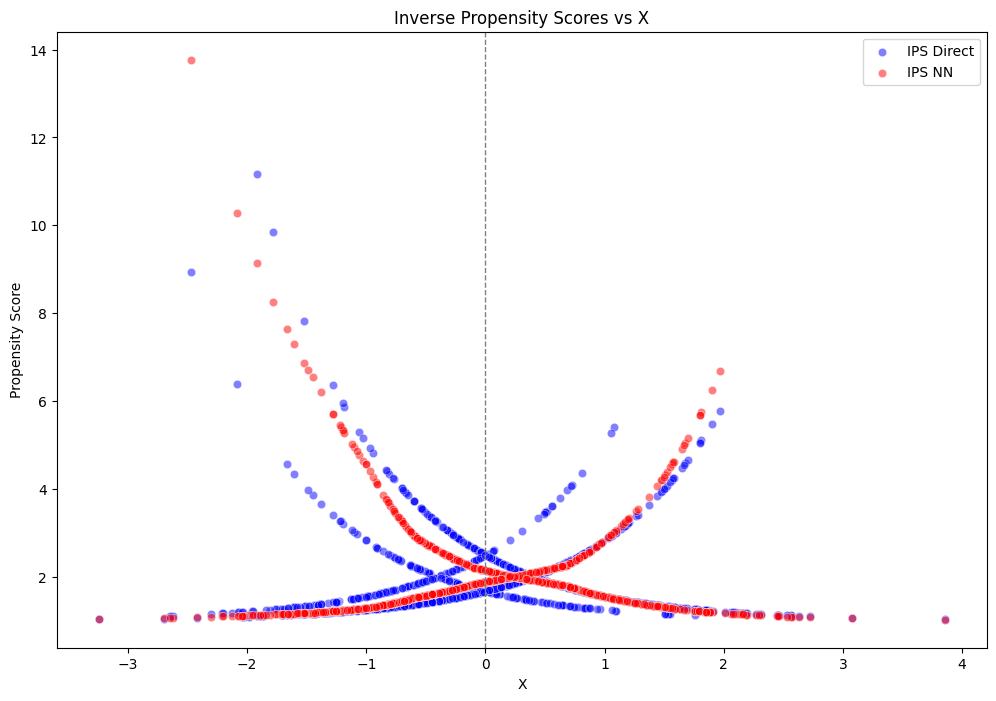

In [127]:
# First, create the pi column (pi0 when T=0, pi1 when T=1)
data_full['pi'] = np.where(data_full['T'] == 0, pi0, pi1)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each method with different colors and labels
sns.scatterplot(x='X', y='ips direct', data=data_full, alpha=0.5, label='IPS Direct', color='blue')
#sns.scatterplot(x='X', y='ips logistic', data=data_full, alpha=0.5, label='IPS Logistic', color='red')
sns.scatterplot(x='X', y='ips NN', data=data_full, alpha=0.5, label='IPS NN', color='red')
#sns.scatterplot(x='X', y='ips XGB', data=data_full, alpha=0.5, label='IPS XGB', color='green')
#sns.scatterplot(x='X', y='pi', data=data_full, alpha=0.5, label='True pi', color='purple')

# Add vertical line at x=0
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Customize the plot
plt.title('Inverse Propensity Scores vs X')
plt.xlabel('X')
plt.ylabel('Propensity Score')
plt.legend()

plt.show()

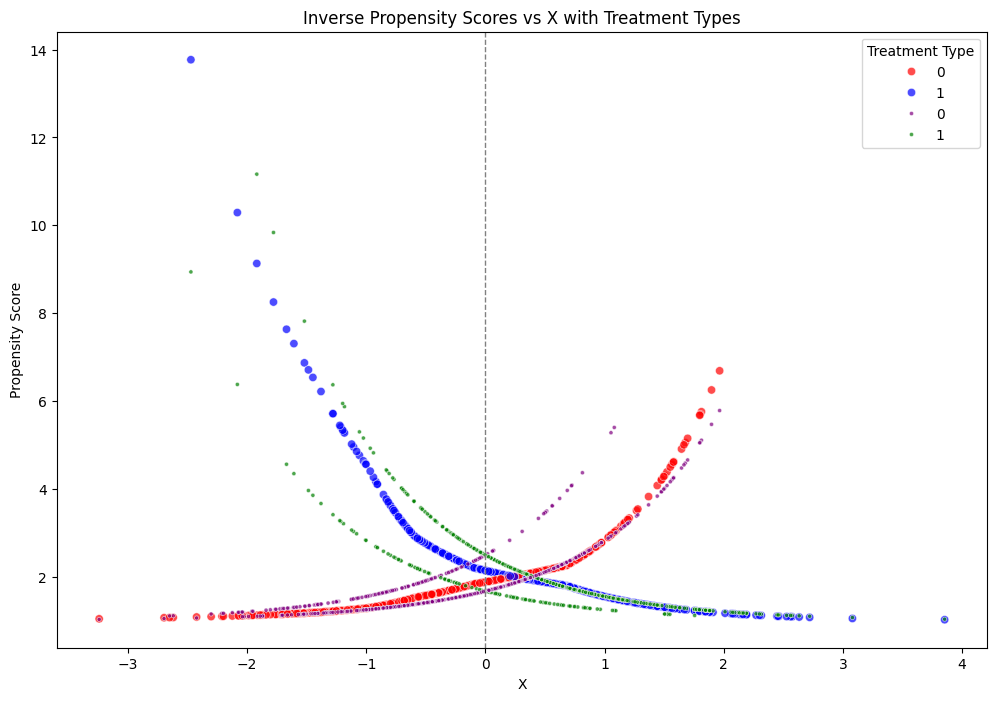

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# First, create the pi column (pi0 when T=0, pi1 when T=1)
data_full['pi'] = np.where(data_full['T'] == 0, pi0, pi1)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot IPS NN outcome, color by treatment type
sns.scatterplot(x='X', y='ips NN', hue='T', data=data_full, alpha=0.7, palette={0: 'red', 1: 'blue'})

# Plot true propensity scores
sns.scatterplot(x='X', y='ips direct', hue='T', data=data_full, alpha=0.7, marker='.', palette={0: 'purple', 1: 'green'})

# Add vertical line at x=0
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Customize the plot
plt.title('Inverse Propensity Scores vs X with Treatment Types')
plt.xlabel('X')
plt.ylabel('Propensity Score')
plt.legend(title='Treatment Type')

plt.show()

In [115]:
IPS_weights_flat = IPS_weights.flatten() if hasattr(IPS_weights, 'flatten') else IPS_weights
print(IPS_weights_flat)

[ 2.1434295  1.8003677  2.2353709  1.295515   1.7317474  2.3665707
  1.2766349  1.7181094  2.7026663  2.170601   1.5906335  1.5893644
  1.9964755  1.1235557  1.144098   2.8562543  1.2782501  1.9602515
  4.1070333  1.1860002  1.3161283  1.7375001  1.9122655  1.1841199
  2.8255837  2.0693765  1.2418902  2.0746975  2.9373271  2.4421105
  1.5153286  1.2007014  1.8710688  4.7611456  2.4857113  1.2253572
  2.0135152  1.1189632  1.2021254  1.9806174  1.7429749  2.0331707
  1.8174685  1.6873552  1.1762105  1.4297754  2.6887245  1.5109179
  1.9459119  1.1396817  1.955425   1.63546    3.1782763  1.8245453
  1.5268447  1.5923433  1.3577455  2.4659214  1.9519176  1.5623198
  1.582037   1.7656825  1.2530907  1.2310554  2.4683218  1.3595002
  2.1859152  1.5441267  2.066984   1.4820713  2.066852   1.2903494
  1.8600465  4.5535135  1.0693977  1.6735867  1.9224776  1.6887035
  2.0811272  1.1162839  1.7417204  1.9393958  4.2091203  1.561243
  1.375041   1.5699338  1.6034992  1.9531436  2.800912   1.8671

Save to CSV to use in another notebook:

In [131]:
data_observed.to_csv('data_observed.csv', index=False)